# Project

Given only 250 images of CIFAR-10 we are going to train a Wide-ResNet algorithm to classify all the images of the dataset, by harnessing the power of FixMatch to do Semi-Supervised Learning !

# Data

The CIFAR-10 dataset is comprised of 60,000 colored images, each with a size of 32x32 pixels, and divided into 10 distinct categories. Each category contains 6,000 images. Out of the 60,000 images, 50,000 are designated for training, while the remaining 10,000 are reserved for testing.

The dataset is organized into six batches: five of them are for training, and one is for testing. Each batch contains 10,000 images. The testing batch includes 1,000 images from each class, chosen at random. As for the training batches, they hold the rest of the images in a random sequence, though the distribution of images from various classes might not be equal within each batch. Collectively, the training batches contain precisely 5,000 images from every class.

![Examples of CIFAR-10 images from all classes](images/cifar10.png)

# FixMatch

## Principle

FixMatch is an algorithm for semi-supervised learning.
The idea is quite simple. Do supervised over the labeled dataset.
Use the trained model over a special unlabeled dataset to produce pseudo-label.
This special dataset is created based on the unlabeled dataset.
For each image of this dataset, we genereate two versions. One Weakly augmented, one strongly augmented. 
The argmax prediction over the weakly augmented one is the pseudo-label. The prediction over the strongly augmented one is compared to the pseudo-label which plays the role of (an evolving) ground truth.
That being said, the pseudo-label is accepted only if it goes above a threshold, a fixed hyperparameter.
Losses are calculated for the supervised and unsupervised part then summed.

Formally, the total loss for a batch of the supervised learning part is defined as $$l_s = \frac{1}{B} \sum_{b=1}^{B}H(p_b, p_m(y|\alpha(x_b)))$$ with $\alpha(x_b)$ the input preprocessed image $x_b$, $B$ the size of the batch, $p_b$ the actual label, $p_m(y|\alpha(x_b))$ the predicted probability of each label knowing the input and $H$ the cross-entropy loss.\
Similarly, the total loss for a batch of the unsupervised learning part is $$l_u = \frac{1}{\mu B} \sum_{b=1}^{\mu B} \mathbb{1} (max(q_b) \geq \tau) H(\hat{q}_b, p_m(y|A(u_b)))$$, with $\hat{q}_b = argmax(q_b) = argmax(p_m(y|\alpha (u_b)))$ the pseudo-label, $p_m(y|A(u_b))$ the predicted probability of each label knowing the strongly augmented image, $\tau$ the threshold to accept the pseudo-label. Beware that we compute the mean over $\mu B$ even if only parts of the strongly augmented have a probability above threshold.\
The final total loss is $L = l_s+\lambda_u l_u$ with $\lambda_u$ another fixed hyperparameter that weighs the unsupervised part.

## Limits

Overall FixMatch is simple and provides results above the methods of its time (UDA, ReMixMatch) as shown in the original paper.\
The catch is to find the strong augmentations that will yield the best results for one's dataset. You will find examples of the augmentations implemented here below.

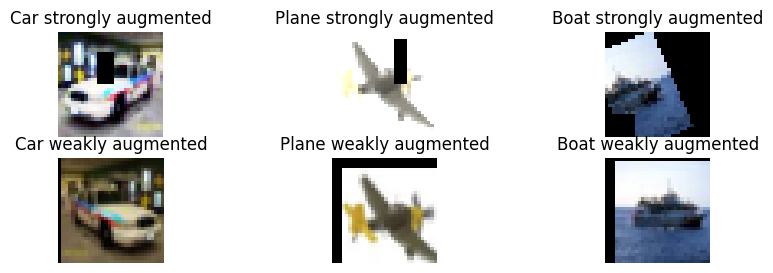

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

# Load images
a1 = Image.open('../transformed_images/input_u_strongly_augmented_0.png')
a2 = Image.open('../transformed_images/input_u_weakly_augmented_0.png')
b1 = Image.open('../transformed_images/input_u_strongly_augmented_1.png')
b2 = Image.open('../transformed_images/input_u_weakly_augmented_1.png')
c1 = Image.open('../transformed_images/input_u_strongly_augmented_2.png')
c2 = Image.open('../transformed_images/input_u_weakly_augmented_2.png')

# Create a figure and axes for subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 3))

# Display images
axes[0, 0].imshow(a1)
axes[0, 0].set_title('Car strongly augmented')
axes[1, 0].imshow(a2)
axes[1, 0].set_title('Car weakly augmented')
axes[0, 1].imshow(b1)
axes[0, 1].set_title('Plane strongly augmented')
axes[1, 1].imshow(b2)
axes[1, 1].set_title('Plane weakly augmented')
axes[0, 2].imshow(c1)
axes[0, 2].set_title('Boat strongly augmented')
axes[1, 2].imshow(c2)
axes[1, 2].set_title('Boat weakly augmented')

# Remove axis ticks and labels
for ax in axes.flatten():
    ax.axis('off')

# Display the figure
plt.show()

## Implementation subtlety

When implementing FixMatch, one must be cautious about the Exponential Moving Average model is updated. It must not cause the gradients of the original model to be disturbed by affecting backward propagation with the exponential moving average caculation or by setting the original model to eval inadvertently. 

Also the unlabeled data should be loaded at random whenever a labeled data is loaded, in the correct proportions. Yet for one unlabeled weakly transformed image should correspond one unlabeled strongly transformed image.\
Still regarding data, **loading data is different** with FixMatch, contrary to a classical machine learning task. Classicaly, one epoch finishes when the model trained on all the examples in the training set. However in FixMatch, one epoch is made of a predefined number of steps. That number of steps can be larger than the number of batches needed to see all the training set. For one given epoch, a training image is seen several times by the model with several randomly weakly/strongly augmented images associated. In this code I manage this subtlety with custom Datasets.

Last but not least, make sure to use the same parameters as in the original paper, an extensive ablation study is performed. There is no need to alter these parameters, except for testing purposes, for instance to get quicker results and see what is wrong. 

That being said, in its current form my implementation is not working properly and yields surprising results.

## Discussing parameters

Among the parameters of the project, some are particularly important as they are at the heart of FixMatch. Other parameters might have a significant impact on performances like the weight decay. As said in the FixMatch paper, under a low label regime, one order of magnitude can cost 10 points on the error rate.  

$\mu, \lambda_{\mu}$ are specific to FixMatch. Increasing $\mu$ will result in better performances as we feed more unlabeled data to FixMatch to process and it decides "on its own" of its curriculum, meaning what it keeps because it is sure of its predictions. However the impact quickly diminishes as $\mu$ increases. Above 10 the differences are very low according to the graphs on the FixMatch paper.\
$\lambda_{\mu}$ looks important at first. This models the importance of the cases that the model incorporates in its training thought the FixMatch process. Here we quote the paper intuition, "We found that this was unnecessary for FixMatch, which may be due to the fact that max(qb) is typically less than τ early in training. As training progresses, the model’s predictions
become more confident and it is more frequently the case that max(qb) > τ . This suggests that
pseudo-labeling may produce a natural curriculum “for free”.[...]"

## Results

### Expectation

If my code was perfectly working I would get results like [these](https://github.com/kekmodel/FixMatch-pytorch) from [kekmodel](https://github.com/kekmodel):

| Labels | (40) | *250* | (4000) |
|:---:|:---:|:---:|:---:|
| Paper (RA) | 86.19 ± 3.37 | 94.93 ± 0.65 | 95.74 ± 0.05 |
| This code | 93.60 | 95.31 | 95.77 |
| Acc. curve | [link](https://tensorboard.dev/experiment/YcLQA52kQ1KZIgND8bGijw/) | [link](https://tensorboard.dev/experiment/GN36hbbRTDaBPy7z8alE1A/) | [link](https://tensorboard.dev/experiment/5flaQd1WQyS727hZ70ebbA/) |


Below, we can contemplate the consistant decrease in train losses. 
Note also that as epochs go, the proportion of strongly augmented that are predicted the same as the weak ones (above a high threshold of 0.95) is rocketing at the beginning then slowing down. This phenomenon corresponds to the steep learning curve of the model at first, which gains confidence in its results quickly and robustly is able to predict correctly on the unlabeled data.

![Magnificient train results by kekmodel](images/perfect_train.png)

There is even a small uptick at the end of the test loss curve, suggesting overfitting yet early-stopping before performances really decrease.

![Magnificient test results by kekmodel](images/perfect_test.png)

### Reality

My results look somewhat okay at first but decline we go through epochs. In order to determine the causes of the errors, I plot several indicators to monitor possible sources of failure. In the following, you will see two runs with different sets of parameters.

All the plots are made thanks to Weights And Biases which provides a practical web interface. I found the interface easier to use than of Tensorboard with runs more clearly visible and accessible. Also it provides information about the gpu usage.

#### Quasi-self-made implementation

#### Working implementation

I achieve about the same results as shown in [kekmodel implementation](https://github.com/kekmodel/FixMatch-pytorch) by running it.
We can see that the curves are a lot more bumpy than in the illustration.

![train results by me with kekmodel](images/train_perso_gpu6.png)

Note the number of epochs is reduced, the training was halted as we are on our way to get the announced results.

![test results by me with kekmodel](images/test_perso_gpu6.png)

Surprisingly a sudden degradation on the training loss was accompanied by an augmentation on the test loss. The obtained accuracy is around 91% at the end of that training.

To try to achieve better results in a limited time, I augmented $\mu$ to 12.

![train results by me with kekmodel mu 12](images/train_perso_gpu4.png)

The training is less stable yet at the end, the overall accuracy reaches around 95%.

![test results by me with kekmodel mu 12](images/test_perso_gpu4.png)

# Appendix

## Wide residual networks

Although we do not modify the architecture in this project, we explore the specifities of it.

### Formula

Residual block formula : 
$$
    x_{l+1} = x_l + \mathcal{F}(x_l, \mathcal{W}_l)
$$
With $x_{l+1}$ and $x_l$ inputs and outputs of the $l$-th unit in the network. $\mathcal{F}$ a residual function and $\mathcal{W}_l$ the parameters of the block.
There are 2 types of blocks in a residual network :
* basic : Batch-Normalization then Relu then convolution with a $3 \times 3$ kernel, all of that twice sequentially. $BN - Relu - conv(3 \times 3) - BN - Relu - conv(3 \times 3)$
* bottleneck : $conv(1 \times 1) - conv(3 \times 3) - conv(3 \times 3) - conv(1 \times 1)$ with $conv(1 \times 1)$

Bottleneck blocks are not considered in WideResNet since their goal of enabling longer neural networks (NN) is shown counterproductive by WideResNet architecture which focuses on width of the NN. More specifically, the WideResNet paper focuses on widening basic block to improve their expressiveness.

The paper introduces two factors : 
* deepening factor l, number of convolutions in a basic block
* widening factor k, number of features in convolutionnal layers

Kernel size remains equal to 3.

### Structure

| Group Name | Output Size | Block Type = $\mathcal{B}(3, 3)$ |
|------------|-------------|----------------------|
| conv1      | 32x32       | [3x3, 16]            |
| conv2      | 32x32       | [3x3, 16xk]          |
|            |             | [3x3, 16xk] xN       |
| conv3      | 16x16       | [3x3, 32xk]          |
|            |             | [3x3, 32xk] xN       |
| conv4      | 8x8         | [3x3, 64xk]          |
|            |             | [3x3, 64xk] xN       |
| avg-pool   | 1x1         | [8x8]                |

For instance the second group is a convolution type group whose output size is $32\times 32$. Its content is two $conv(3 \times 3) \times (16\times k)$ features or channels all of that repeated N times to make a sequence.

As for the notation, WRN-n-k denotes a residual networks with n convolutionnal layers in total and a widening factor k. For this project we use WRN-28-2. The [official implementation](https://github.com/szagoruyko/wide-residual-networks) provides [ways](https://github.com/szagoruyko/wide-residual-networks/blob/ae6d0d0561484172790c7a63c8ce6ade5a5a2914/models/wide-resnet.lua#L89) to compute N = $(28-4)/6$ (but why is there a 4 ? I could not find a real explanation, and I am not the only [one](https://github.com/szagoruyko/wide-residual-networks/issues/54#issue-341894131). My guess is that the 4 layers are the conv1 at the beginning, and the different layers at the end).

The WRN-28-2 structure can be written as followed, with possible variations for the end groups :

| Group Name | Output Size | Block Type                   |
|------------|-------------|------------------------------|
| conv1      | 32x32       | [3x3, 16]                    |
| conv2      | 32x32       | [3x3, 32]                    |
|            |             | [3x3, 32] x4 (N=4)           |
| conv3      | 16x16       | [3x3, 64] (stride 2)         |
|            |             | [3x3, 64] x4 (N=4)           |
| conv4      | 8x8         | [3x3, 128] (stride 2)        |
|            |             | [3x3, 128] x4 (N=4)          |
| BN+Relu    |             |                              |
| avg-pool   | 1x1         | [8x8]                        |
| linear     |             |                              |

In addition to this structure, a Dropout layer is inserted in-between the $BN - Relu - conv(3 \times 3)$ of a basic block.

## Exponential Moving Average

Original FixMatch paper relies on the Exponential Moving Average technic to report performances of the trained algorithm.\
According to the original [code](https://github.com/google-research/fixmatch/blob/d4985a158065947dba803e626ee9a6721709c570/imagenet/utils/ema.py#L19) of EMA for FixMatch, it looks like the goal is to have a model with a lot of inertia. It remains 0.999 the same at each step ! Fortunately that means that at the end of the 1024 steps training of this code, the model is less than 35% of its initial version : $0.999^{1024}$. That is one reason for which the high fixed number of steps is important, without it the EMA model would not update as much and show poor performances. 